In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil.relativedelta import relativedelta

In [44]:
# S&P 500 Data
sp500 = pd.read_csv('sp500_data.csv', index_col='Date')
sp500.index = pd.to_datetime(sp500.index)
sp500.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2006-01-03,1248.290039,1270.219971,1245.739990,1268.800049,1268.800049,2554570000
2006-01-04,1268.800049,1275.369995,1267.739990,1273.459961,1273.459961,2515330000
2006-01-05,1273.459961,1276.910034,1270.300049,1273.479980,1273.479980,2433340000
2006-01-06,1273.479980,1286.089966,1273.479980,1285.449951,1285.449951,2446560000
2006-01-09,1285.449951,1290.780029,1284.819946,1290.150024,1290.150024,2301490000


In [45]:
# Market-based Density Data
mbd = pd.read_csv('data\sp6m_6.csv', index_col='idt').iloc[:, 1:]
mbd.index = pd.to_datetime(mbd.index)
mbd.head()

,market,maturity_target,mu,sd,skew,kurt,p10,p50,p90,lg_change_decr,prDec,lg_change_incr,prInc
idt,,,,,,,,,,,,,
2007-01-12,sp6m,6.0,0.018803,0.086435,-1.079705,1.837194,-0.095498,0.03382,0.111149,-20.0,0.024242,20.0,0.001915
2007-01-31,sp6m,6.0,0.018350,0.077969,-1.046439,1.842209,-0.083769,0.03099,0.102377,-20.0,0.016758,20.0,0.000767
2007-02-15,sp6m,6.0,0.019976,0.084543,-1.001081,1.588657,-0.092096,0.03361,0.111834,-20.0,0.021096,20.0,0.001900
2007-02-28,sp6m,6.0,0.018823,0.100147,-1.031801,1.638698,-0.114332,0.03565,0.126683,-20.0,0.036788,20.0,0.007350
2007-03-15,sp6m,6.0,0.018767,0.099519,-1.058040,1.823271,-0.112902,0.03536,0.125505,-20.0,0.036138,20.0,0.007715


In [46]:
# Write a function that compute maturity date
def maturity_time(idt, maturity, trading_dates):
    maturity_dates = []
    for date in idt:
        # Add 6 months to the current date using relativedelta
        maturity_date = date + relativedelta(months=maturity)
        if maturity_date in trading_dates:
            maturity_dates.append(maturity_date)
        else:
            future_dates = [d for d in trading_dates if d > maturity_date]
            if future_dates:
                maturity_dates.append(future_dates[0])
            else:
                maturity_dates.append(None)
    return pd.to_datetime(maturity_dates)

# Compute maturity date
mbd_maturity = maturity_time(mbd.index, 6, sp500.index)

In [47]:
# Create a map to store returns
log_returns = {}
for idt, m1, m2 in zip(mbd.index, mbd_maturity[:-1], mbd_maturity[1:]):
    # idt daily price
    idt_price = sp500.loc[sp500.index==idt]['Close']
    if len(idt_price) == 0:
        idt_price = sp500.loc[sp500.index==idt-relativedelta(days=1)]['Close']
    idt_price = idt_price[0]
    # Obtain 14-day prices after 6 months
    prices = np.array(sp500.loc[(sp500.index >= m1) & (sp500.index < m2)]['Close'])
    # Check if S&P 500 index avaliable
    if len(prices) != 0:
        log_return = np.log(prices / idt_price)
    log_returns[idt] = log_return

C:\Users\azhe1\AppData\Local\Temp\ipykernel_34544\1580626486.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  idt_price = idt_price[0]


In [48]:
# Consider short-term (7-14 days) reversals
# 1: positive reversal
# 0: no reversal
# -1: negative reversal

# Compute maturity date
mbd_maturity = maturity_time(mbd.index, 6, sp500.index)

# Create a map to store average prices, high prices, low prices, open prices and close prices during each period
avg_prices = []
max_prices = []
min_prices = []
open_prices = []
close_prices = []
daily_prices = {}

for idt, m1, m2 in zip(mbd.index, mbd_maturity[:-1], mbd_maturity[1:]):
    # idt daily price
    idt_price = sp500.loc[sp500.index==idt]['Close']
    if len(idt_price) == 0:
        idt_price = sp500.loc[sp500.index==idt-relativedelta(days=1)]['Close']
    idt_price = idt_price[0]
    # Obtain and compute mean of 14-day prices after 6 months
    avg_price = np.mean(sp500.loc[(sp500.index >= m1) & (sp500.index < m2)]['Close'])
    max_price = np.max(sp500.loc[(sp500.index >= m1) & (sp500.index < m2)]['High'])
    min_price = np.min(sp500.loc[(sp500.index >= m1) & (sp500.index < m2)]['Low'])
    # df_m1 = sp500.loc[sp500.index == m1]
    if m1 in sp500.index:
        open_price = sp500.loc[m1]['Open']
    else:
        open_price = np.nan
    if m2 in sp500.index:
        close_price = sp500.loc[m2]['Close']
    else:
        close_price = np.nan
    # Records real index average price
    avg_prices.append(avg_price)
    max_prices.append(np.log(max_price/idt_price))
    min_prices.append(np.log(min_price/idt_price))
    open_prices.append(np.log(open_price/idt_price))
    close_prices.append(np.log(close_price/idt_price))
    # Record daily prices during that period
    daily_prices[idt] = sp500.loc[(sp500.index >= m1) & (sp500.index < m2)]

# Since the last annoucement date doesn't have maturity date's price, fill by np.nan
avg_prices.append(np.nan)
max_prices.append(np.nan)
min_prices.append(np.nan)
open_prices.append(np.nan)
close_prices.append(np.nan)

# Add columns to mbd
mbd['Avg'] = avg_prices
mbd['Open'] = open_prices
mbd['High'] = max_prices
mbd['Low'] = min_prices
mbd['Close'] = close_prices
mbd.head()

# Write as csv file
mbd.to_csv('mbd.csv')

C:\Users\azhe1\AppData\Local\Temp\ipykernel_34544\889008814.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  idt_price = idt_price[0]


# Short-term Reversals

In [49]:
data = mbd.iloc[:, 2:]
data.shape

(685, 16)

In [50]:
# Calculate upper shadow（上影线）
uw = []
# Calculate lower shadow
lw = []
for i in range(data.shape[0]):
    high = data['High']
    low = data['Low']
    open = data['Open']
    close = data['Close']
    uw.append(high[i]-max([open[i], close[i]]))
    lw.append(min([open[i], close[i]])-low[i])

data['upper shadow'] = uw
data['lower shadow'] = lw

C:\Users\azhe1\AppData\Local\Temp\ipykernel_34544\866514137.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  uw.append(high[i]-max([open[i], close[i]]))
C:\Users\azhe1\AppData\Local\Temp\ipykernel_34544\866514137.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lw.append(min([open[i], close[i]])-low[i])


In [51]:
data.corr()

,mu,sd,skew,kurt,p10,p50,p90,lg_change_decr,prDec,lg_change_incr,prInc,Avg,Open,High,Low,Close,upper shadow,lower shadow
mu,1.000000,-0.516717,-0.110128,0.250222,0.634223,0.523496,-0.322638,NaN,-0.618448,NaN,-0.401819,0.441063,-0.203585,-0.230737,-0.176741,-0.210080,-0.015187,-0.090382
sd,-0.516717,1.000000,0.272645,-0.394792,-0.985611,0.321655,0.964456,NaN,0.983075,NaN,0.953499,-0.039836,0.194284,0.240199,0.153294,0.197271,0.156193,0.132062
skew,-0.110128,0.272645,1.000000,-0.941130,-0.290898,-0.212569,0.410377,NaN,0.287373,NaN,0.428561,-0.416006,-0.037491,-0.009244,-0.075715,-0.049177,0.211132,0.160871
kurt,0.250222,-0.394792,-0.941130,1.000000,0.440939,0.133988,-0.480621,NaN,-0.429914,NaN,-0.498755,0.527419,0.009782,-0.023637,0.055011,0.022302,-0.223158,-0.182898
p10,0.634223,-0.985611,-0.290898,0.440939,1.000000,-0.213978,-0.920552,NaN,-0.989520,NaN,-0.928854,0.144370,-0.200408,-0.247120,-0.156937,-0.203065,-0.152808,-0.142337
p50,0.523496,0.321655,-0.212569,0.133988,-0.213978,1.000000,0.398532,NaN,0.201077,NaN,0.320391,0.428780,0.033256,0.042244,0.027344,0.029657,0.061116,-0.004027
p90,-0.322638,0.964456,0.410377,-0.480621,-0.920552,0.398532,1.000000,NaN,0.926357,NaN,0.971339,-0.002626,0.145086,0.191341,0.103430,0.146198,0.189663,0.142592
lg_change_decr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
prDec,-0.618448,0.983075,0.287373,-0.429914,-0.989520,0.201077,0.926357,NaN,1.000000,NaN,0.914190,-0.134433,0.171839,0.218823,0.127323,0.173584,0.166297,0.151265
lg_change_incr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


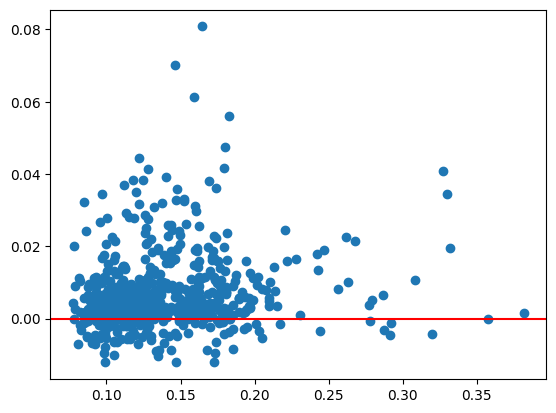

In [52]:
plt.scatter(data['sd'], uw)
plt.axhline(0, color='red')

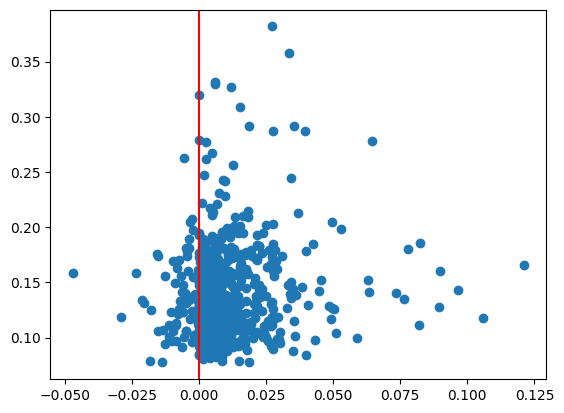

In [53]:
plt.scatter(lw, data['sd'])
plt.axvline(0, color='red')

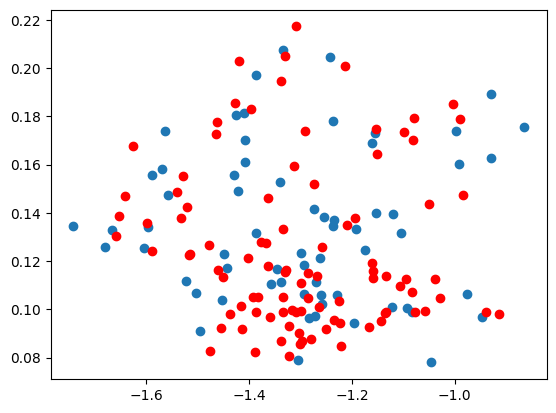

In [54]:
df1 = data[(data['upper shadow'] > 0) & (data['lower shadow'] < 0)]
df2 = data[(data['upper shadow'] < 0) & (data['lower shadow'] > 0)]
df1_ = df1[(df1['skew']<-0.8) & (df1['sd']<0.22)]
df2_ = df2[(df2['skew']<-0.8) & (df2['sd']<0.22)]

plt.scatter(df1_['skew'], df1_['sd'])
plt.scatter(df2_['skew'], df2_['sd'], color="r")

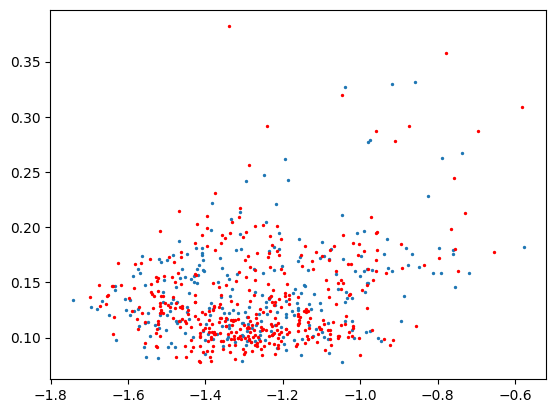

In [55]:
df3 = data[data['upper shadow'] > data['lower shadow']]
df4 = data[data['upper shadow'] < data['lower shadow']]
plt.scatter(df3['skew'], df3['sd'], s=2)
plt.scatter(df4['skew'], df4['sd'], color="r", s=2)

In [56]:
df3.corr()

,mu,sd,skew,kurt,p10,p50,p90,lg_change_decr,prDec,lg_change_incr,prInc,Avg,Open,High,Low,Close,upper shadow,lower shadow
mu,1.000000,-0.526370,-0.130416,0.233665,0.641211,0.541126,-0.342676,NaN,-0.624581,NaN,-0.398911,0.419464,-0.214618,-0.244753,-0.202541,-0.214312,-0.034544,0.015781
sd,-0.526370,1.000000,0.315144,-0.398518,-0.985334,0.274928,0.966824,NaN,0.984958,NaN,0.952285,-0.027928,0.180202,0.228821,0.164693,0.190598,0.199558,0.150481
skew,-0.130416,0.315144,1.000000,-0.951726,-0.332343,-0.240706,0.454332,NaN,0.329773,NaN,0.471796,-0.405325,-0.059768,-0.029500,-0.071995,-0.060376,0.257592,0.091400
kurt,0.233665,-0.398518,-0.951726,1.000000,0.442861,0.164661,-0.495783,NaN,-0.433482,NaN,-0.507140,0.512384,0.021826,-0.011622,0.037314,0.027058,-0.272855,-0.079561
p10,0.641211,-0.985334,-0.332343,0.442861,1.000000,-0.170416,-0.924649,NaN,-0.992580,NaN,-0.923117,0.136660,-0.189897,-0.239488,-0.173441,-0.198089,-0.201615,-0.130173
p50,0.541126,0.274928,-0.240706,0.164661,-0.170416,1.000000,0.343968,NaN,0.171378,NaN,0.264552,0.465011,-0.001789,0.000641,-0.001953,0.000819,0.067675,0.098553
p90,-0.342676,0.966824,0.454332,-0.495783,-0.924649,0.343968,1.000000,NaN,0.930127,NaN,0.977489,0.009475,0.122820,0.171496,0.107953,0.134957,0.238272,0.177691
lg_change_decr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
prDec,-0.624581,0.984958,0.329773,-0.433482,-0.992580,0.171378,0.930127,NaN,1.000000,NaN,0.914854,-0.122496,0.174853,0.223363,0.156422,0.180533,0.206816,0.133074
lg_change_incr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [57]:
np.mean(df2['mu'])

-0.0003722680198019806

# Mid-term Reversals

In [58]:
# Label reversals: mid-term
# 将两个时间点之间的那个时间段看作一个整体来进行分析，以为这reversals转点会出现在那个时间段的任意一天
# 缺点：无法精确具体的交易时间点，无法应用到策略当中
reversal = [0]
for i in range(1, len(avg_prices)-1):
    if avg_prices[i] <= avg_prices[i-1] and avg_prices[i] <= avg_prices[i+1]:
        reversal.append(1)
    elif avg_prices[i] >= avg_prices[i-1] and avg_prices[i] >= avg_prices[i+1]:
        reversal.append(-1)
    else:
        reversal.append(0)
reversal.append(0)
data = mbd.copy()
data['Reversal'] = reversal
data.head()

,market,maturity_target,mu,sd,skew,kurt,p10,p50,p90,lg_change_decr,prDec,lg_change_incr,prInc,Avg,Open,High,Low,Close,Reversal
idt,,,,,,,,,,,,,,,,,,,
2007-01-12,sp6m,6.0,0.018803,0.086435,-1.079705,1.837194,-0.095498,0.03382,0.111149,-20.0,0.024242,20.0,0.001915,1524.512301,0.059696,0.083869,0.016354,0.017007,0
2007-01-31,sp6m,6.0,0.018350,0.077969,-1.046439,1.842209,-0.083769,0.03099,0.102377,-20.0,0.016758,20.0,0.000767,1459.490922,0.024492,0.044635,-0.008407,-0.022174,0
2007-02-15,sp6m,6.0,0.019976,0.084543,-1.001081,1.588657,-0.092096,0.03361,0.111834,-20.0,0.021096,20.0,0.001900,1447.701104,-0.021271,0.015387,-0.061001,-0.016926,1
2007-02-28,sp6m,6.0,0.018823,0.100147,-1.031801,1.638698,-0.114332,0.03565,0.126683,-20.0,0.036788,20.0,0.007350,1468.039241,0.041697,0.061730,0.017747,0.048444,0
2007-03-15,sp6m,6.0,0.018767,0.099519,-1.058040,1.823271,-0.112902,0.03536,0.125505,-20.0,0.036138,20.0,0.007715,1518.845007,0.063960,0.100021,0.055557,0.105401,0


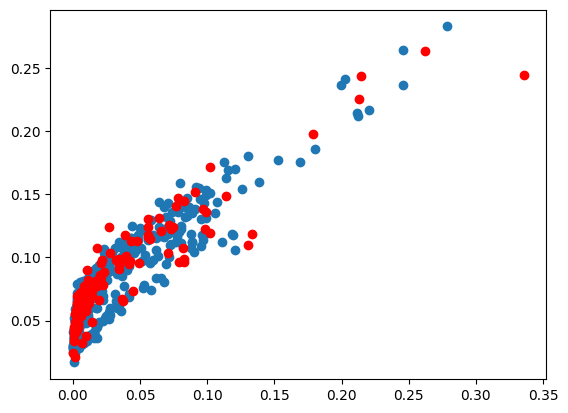

In [59]:
df1 = data[data['Reversal']==0]
df2 = data[data['Reversal']==1]
plt.scatter(df1['prInc'], df1['prDec'])
plt.scatter(df2['prInc'], df2['prDec'], color="r")

# Visualization

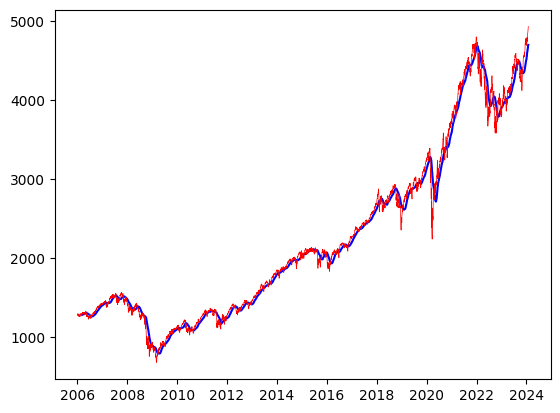

In [60]:
plt.plot(sp500.rolling(window=50).mean()['Close'], color='b')
plt.plot(sp500['Close'], color='r', linewidth=0.5)

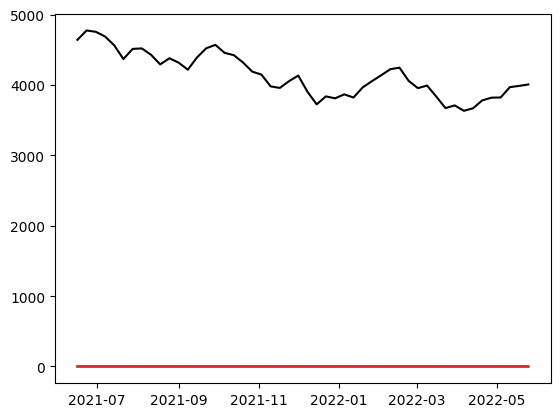

In [61]:
plt.plot(mbd['Avg'][550:600], color='black')
plt.plot(mbd['Open'][550:600])
plt.plot(mbd['Close'][550:600])
plt.plot(mbd['High'][550:600])
plt.plot(mbd['Low'][550:600])

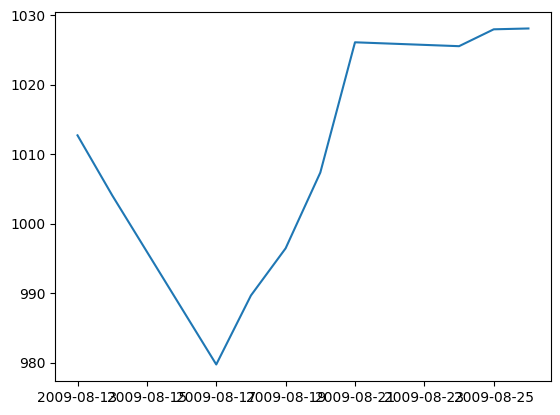

In [62]:
plt.plot(daily_prices[mbd.index[50]]['Close'])

对于reversal，我三个数据为一组，以rolling window的方式查看

新的数据集，每行有三个mu， std， skew，kurtosis，